Random Forest Accuracy: 0.9108189582984425

Classification Report:
                precision    recall  f1-score   support

     BROWSING       0.93      0.95      0.94      2022
         CHAT       0.83      0.83      0.83       476
           FT       0.94      0.77      0.85       832
         MAIL       0.93      0.75      0.83       259
          P2P       0.97      0.97      0.97       829
    STREAMING       0.90      0.80      0.85       215
         VOIP       0.98      0.97      0.98      1294
 VPN-BROWSING       0.92      0.92      0.92      1984
     VPN-CHAT       0.84      0.76      0.80       576
       VPN-FT       0.86      0.84      0.85       917
     VPN-MAIL       0.89      0.97      0.93       519
      VPN-P2P       0.72      0.98      0.83       683
VPN-STREAMING       0.97      0.97      0.97       236
     VPN-VOIP       0.97      0.95      0.96      1100

     accuracy                           0.91     11942
    macro avg       0.90      0.89      0.89     1

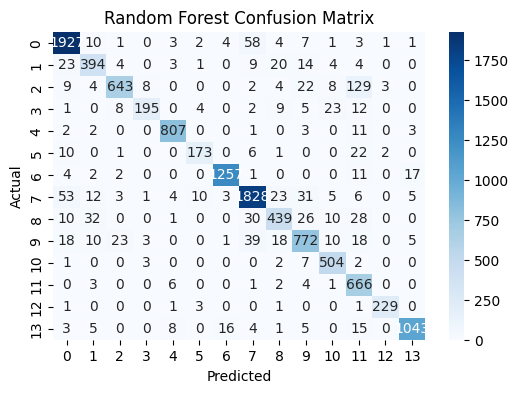

In [22]:
# =============================================
# Random Forest Classifier
# =============================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv("data/consolidated_traffic_data.csv")

# Features and target
features = [
    "duration", "total_fiat", "total_biat", "min_fiat", "min_biat",
    "max_fiat", "max_biat", "mean_fiat", "mean_biat",
    "flowPktsPerSecond", "flowBytesPerSecond",
    "min_flowiat", "max_flowiat", "mean_flowiat", "std_flowiat",
    "min_active", "mean_active", "max_active", "std_active",
    "min_idle", "mean_idle", "max_idle", "std_idle"
]
X = df[features]
y = df["traffic_type"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest on DataFrame (keeps feature names)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(rf_model, "random_forest_model.pkl")


y_pred_rf = rf_model.predict(X_test)




In [20]:
"""
train_mlp.py
Trains an MLP classifier (neural network), evaluates it, saves model and metrics.
"""

# Imports
import os
import json
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Paths and config
DATA_PATH = "data/consolidated_traffic_data.csv"
RESULTS_DIR = "results"
TARGET_COL = "traffic_type"

os.makedirs(RESULTS_DIR, exist_ok=True)

features = [
    "duration", "total_fiat", "total_biat", "min_fiat", "min_biat",
    "max_fiat", "max_biat", "mean_fiat", "mean_biat",
    "flowPktsPerSecond", "flowBytesPerSecond",
    "min_flowiat", "max_flowiat", "mean_flowiat", "std_flowiat",
    "min_active", "mean_active", "max_active", "std_active",
    "min_idle", "mean_idle", "max_idle", "std_idle"
]

# 1) Load dataset
df = pd.read_csv(DATA_PATH)

# 2) Prepare features and labels
X = df[features].copy()
y_raw = df[TARGET_COL].copy()
le = LabelEncoder()
y = le.fit_transform(y_raw)
joblib.dump(le, os.path.join(RESULTS_DIR, "label_encoder.pkl"))  # save encoder

# 3) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4) Scaling is REQUIRED for MLP (neural nets perform better with scaled input)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(RESULTS_DIR, "scaler.pkl"))

# 5) Define and train MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)

# 6) Predict & evaluate
y_pred = mlp.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

print("MLP Accuracy:", acc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 7) Save metrics and plots
with open(os.path.join(RESULTS_DIR, "mlp_metrics.json"), "w") as f:
    json.dump({"accuracy": acc, "classification_report": report}, f, indent=4)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("MLP - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "mlp_confusion_matrix.png"))
plt.close()

# 8) Save model
joblib.dump(mlp, os.path.join(RESULTS_DIR, "mlp_model.joblib"))
print(f"\nMLP model saved to {os.path.join(RESULTS_DIR, 'mlp_model.joblib')}")
joblib.dump(mlp, "mlp_model.pkl")

# Use scaled test set for predictions (to avoid warning)
y_pred_mlp = mlp.predict(X_test_scaled)




MLP Accuracy: 0.6293753140177525

Confusion Matrix:
 [[1507   28    8   39    9    9    1  307   32   32    6   16    5    1]
 [  84  173    2    2   51    0    2   44   52   11   17   20    0   43]
 [  46    3  361   36   11   14   63   22   11   32   36  151    5    4]
 [   5    1   13  119    0    0    1   14    3    1   75   38    0    3]
 [  31   11    6    0  597    0    0   54    2   22    1   22    0   54]
 [  21    0    2    4    3  124    0   14    3    5    1   51   22    7]
 [   7    2    4    1    1    1 1188    9    2    9    3   22    0   48]
 [ 507   19    4   72   52    7    8 1153   59   51   17   35    3   13]
 [  75   40    5   12   26    1    1   80  204   40   26   58    0    0]
 [  24    5   22   32   91    6    4   91   29  533   43   49    6    6]
 [   2    0   16   41    0    0    5    9    3   12  385   13    3    0]
 [  13    3    1   18   52    8    1   42    3   57    4  388   33   60]
 [   8    0    0    0    7   25    0    5    2    0    0   12  164    0

In [21]:
"""
train_xgboost.py
Trains an XGBoost classifier (XGBClassifier), evaluates it, saves model and metrics.
"""

# Imports
import os
import json
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Paths & config
DATA_PATH = "data/consolidated_traffic_data.csv"
RESULTS_DIR = "results"
TARGET_COL = "traffic_type"

os.makedirs(RESULTS_DIR, exist_ok=True)

features = [
    "duration", "total_fiat", "total_biat", "min_fiat", "min_biat",
    "max_fiat", "max_biat", "mean_fiat", "mean_biat",
    "flowPktsPerSecond", "flowBytesPerSecond",
    "min_flowiat", "max_flowiat", "mean_flowiat", "std_flowiat",
    "min_active", "mean_active", "max_active", "std_active",
    "min_idle", "mean_idle", "max_idle", "std_idle"
]

# 1) Load
df = pd.read_csv(DATA_PATH)

# 2) Prepare features/labels
X = df[features].copy()
y_raw = df[TARGET_COL].copy()
le = LabelEncoder()
y = le.fit_transform(y_raw)
joblib.dump(le, os.path.join(RESULTS_DIR, "label_encoder.pkl"))

# 3) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4) Scaling (XGBoost does not require scaling, but using a scaler keeps consistency if you use the same preprocessor later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(RESULTS_DIR, "scaler.pkl"))

# 5) Train XGBoost using scikit-learn wrapper (easy to save with joblib)
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    eval_metric='mlogloss',
    random_state=42
)
xgb_clf.fit(X_train_scaled, y_train)

# 6) Predict & evaluate
y_pred = xgb_clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

print("XGBoost Accuracy:", acc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 7) Save metrics & plot
with open(os.path.join(RESULTS_DIR, "xgboost_metrics.json"), "w") as f:
    json.dump({"accuracy": acc, "classification_report": report}, f, indent=4)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "xgboost_confusion_matrix.png"))
plt.close()

# 8) Save model
joblib.dump(xgb_clf, os.path.join(RESULTS_DIR, "xgboost_model.joblib"))
print(f"\nXGBoost model saved to {os.path.join(RESULTS_DIR, 'xgboost_model.joblib')}")
joblib.dump(xgb_clf, "xgboost_model.pkl")

y_pred_xgb = xgb_clf.predict(X_test_scaled)



XGBoost Accuracy: 0.9050410316529894

Confusion Matrix:
 [[1882   14    0    0    0    3    0   82    5   13    1    0    0    0]
 [  28  428    1    1    0    0    0   14    7    7    2   11    0    2]
 [   8    3  590    3    1    2    1    5    3   32   10  136    0    1]
 [   1    3    7  215    0    0    0    1    1    9   25   11    0    0]
 [   3    0    0    0  791    0    0    0    0    0    0    6    0    0]
 [   8    0    0    4    0  197    0   12    1    2    0   32    1    0]
 [   5    1    5    0    0    0 1255    2    0    1    0    8    0   20]
 [  57   13    4    1    1    3    0 1859   34   22    1    3    0    2]
 [   9   28    4    8    1    0    0   33  417   27    5   34    0    2]
 [  13    3   17    3    4    0    0   52   25  787   13   18    1    5]
 [   1    0    6    2    0    0    0    4    1    6  465    4    0    0]
 [   0    4    0    0   29    0    0    7    1    3    1  635    0    3]
 [   1    0    1    0    0    0    0    3    0    0    0    5  213 

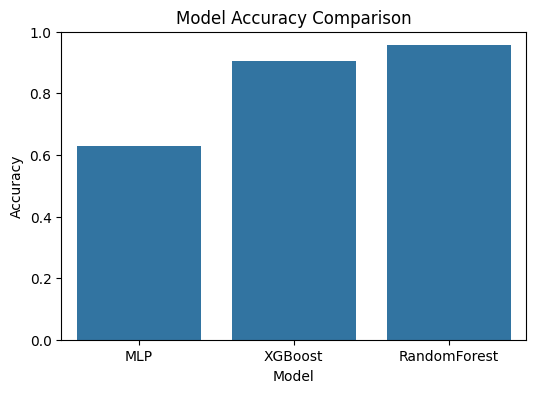

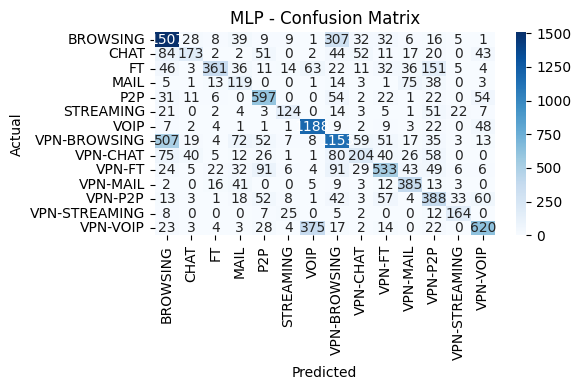

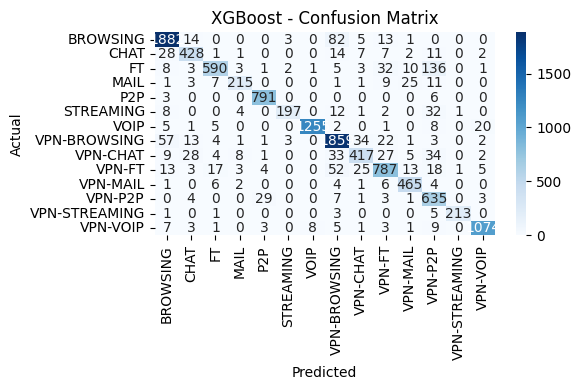

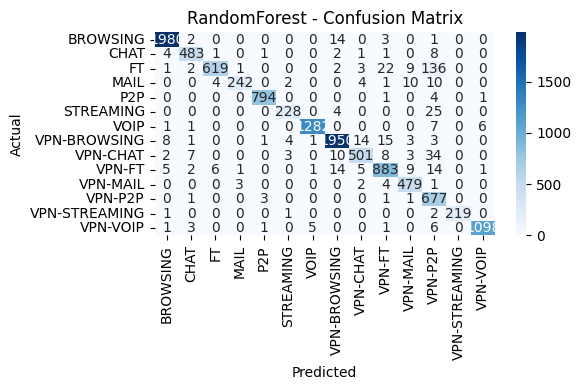

<Figure size 800x500 with 0 Axes>

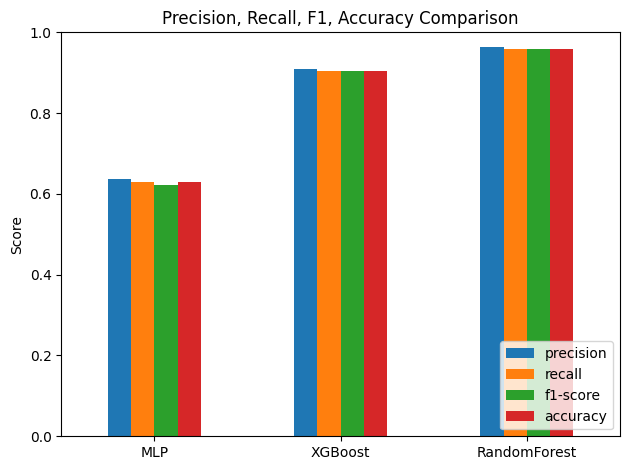


=== Metrics Summary ===
              precision  recall  f1-score  accuracy
MLP              0.6374  0.6294    0.6231    0.6294
XGBoost          0.9094  0.9050    0.9049    0.9050
RandomForest     0.9627  0.9575    0.9580    0.9575


In [27]:
# =============================================
# Model Comparison: MLP vs XGBoost vs RandomForest
# =============================================

import os
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Paths
RESULTS_DIR = "results"
DATA_PATH = "data/consolidated_traffic_data.csv"
TARGET_COL = "traffic_type"

# Features
features = [
    "duration", "total_fiat", "total_biat", "min_fiat", "min_biat",
    "max_fiat", "max_biat", "mean_fiat", "mean_biat",
    "flowPktsPerSecond", "flowBytesPerSecond",
    "min_flowiat", "max_flowiat", "mean_flowiat", "std_flowiat",
    "min_active", "mean_active", "max_active", "std_active",
    "min_idle", "mean_idle", "max_idle", "std_idle"
]

# 1) Load dataset
df = pd.read_csv(DATA_PATH)
X = df[features]
y = df[TARGET_COL]

# Train/test split (same random_state for consistency)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Load preprocessing objects
scaler = joblib.load(os.path.join(RESULTS_DIR, "scaler.pkl"))
le = joblib.load(os.path.join(RESULTS_DIR, "label_encoder.pkl"))

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_test_encoded = le.transform(y_test)

# 3) Load models
mlp = joblib.load(os.path.join(RESULTS_DIR, "mlp_model.joblib"))
xgb_clf = joblib.load(os.path.join(RESULTS_DIR, "xgboost_model.joblib"))
rf_model = joblib.load("random_forest_model.pkl")

# 4) Predictions
preds = {
    "MLP": mlp.predict(X_test_scaled),
    "XGBoost": xgb_clf.predict(X_test_scaled),
    "RandomForest": rf_model.predict(X_test)  # RF trained on raw features
}

# 5) Evaluation
results = {}
for model_name, y_pred in preds.items():
    acc = accuracy_score(y_test_encoded, y_pred) if model_name != "RandomForest" else accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test_encoded if model_name != "RandomForest" else y_test,
        y_pred,
        target_names=le.classes_,
        output_dict=True
    )
    cm = confusion_matrix(
        y_test_encoded if model_name != "RandomForest" else y_test,
        y_pred
    )
    results[model_name] = {"accuracy": acc, "report": report, "confusion_matrix": cm}

# 6) Accuracy bar chart


acc_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [results[m]["accuracy"] for m in results]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=acc_df, x="Model", y="Accuracy", legend=False)

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


# 7) Confusion matrices
for model_name, data in results.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(data["confusion_matrix"], annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# 8) Precision/Recall/F1 comparison
metrics_df = pd.DataFrame({
    model: {
        "precision": data["report"]["weighted avg"]["precision"],
        "recall": data["report"]["weighted avg"]["recall"],
        "f1-score": data["report"]["weighted avg"]["f1-score"],
        "accuracy": data["accuracy"]
    }
    for model, data in results.items()
}).T

plt.figure(figsize=(8, 5))
metrics_df[["precision", "recall", "f1-score", "accuracy"]].plot(kind="bar")
plt.title("Precision, Recall, F1, Accuracy Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("\n=== Metrics Summary ===")
print(metrics_df.round(4))
